In [1]:
import h5py
import torch

hf = h5py.File('data/datasets.h5', 'r')

print(
list(hf.keys()),'\n' , 
hf['val'].keys(),'\n',
hf['val']['X'],'\n',
hf['train'].keys())


#torch.from_numpy(hf['train']['X'][:]).shape, torch.from_numpy(hf['val']['X'][:]).shape



full_X = torch.cat([torch.from_numpy(hf['train']['X'][:]), 
           torch.from_numpy(hf['val']['X'][:])])

hf['val'].keys()

['empirical_mean_for_GRUD', 'test', 'train', 'val'] 
 <KeysViewHDF5 ['X', 'X_hat', 'indicating_mask', 'missing_mask']> 
 <HDF5 dataset "X": shape (4, 9, 51), type "<f4"> 
 <KeysViewHDF5 ['X']>


/DeepenData/.miniconda/envs/torch_aa/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<KeysViewHDF5 ['X', 'X_hat', 'indicating_mask', 'missing_mask']>

In [2]:
from torch.utils.data import Dataset, DataLoader, RandomSampler
import numpy as np
import torch

class LoadDataset(Dataset):
    def __init__(self, file_path, seq_len, feature_num):
        super(LoadDataset, self).__init__()
        self.file_path   = file_path
        self.seq_len     = seq_len
        self.feature_num = feature_num
        #self.model_type  = model_type
        
        
class LoadValTestDataset(LoadDataset):
    """Loads validation set"""

    def __init__(self, file_path, set_name, seq_len, feature_num):
        super(LoadValTestDataset, self).__init__(file_path, seq_len, feature_num)
        with h5py.File(self.file_path, 'r') as hf:  # read data from h5 file
            self.X = hf[set_name]['X'][:]
            self.X_hat = hf[set_name]['X_hat'][:]
            self.missing_mask = hf[set_name]['missing_mask'][:]
            self.indicating_mask = hf[set_name]['indicating_mask'][:]

        # fill missing values with 0
        self.X     = np.nan_to_num(self.X)
        self.X_hat = np.nan_to_num(self.X_hat)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = (
                torch.tensor(idx),
                torch.from_numpy(self.X_hat[idx].astype('float32')),
                torch.from_numpy(self.missing_mask[idx].astype('float32')),
                torch.from_numpy(self.X[idx].astype('float32')),
                torch.from_numpy(self.indicating_mask[idx].astype('float32')),
            )
        return sample
    
    
    
    
class LoadTrainDataset(LoadDataset):
    """Loads train set"""

    def __init__(self, file_path, seq_len, feature_num, masked_imputation_task):
        super(LoadTrainDataset, self).__init__(file_path, seq_len, feature_num)
        self.masked_imputation_task = masked_imputation_task
        if masked_imputation_task:
            self.artificial_missing_rate = 0.1
            assert 0 < self.artificial_missing_rate < 1, 'artificial_missing_rate should be greater than 0 and less than 1'

        with h5py.File(self.file_path, 'r') as hf:  # read data from h5 file
            self.X = hf['train']['X'][:]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        if self.masked_imputation_task:
            X = X.reshape(-1)
            indices = np.where(~np.isnan(X))[0].tolist()
            indices = np.random.choice(indices, round(len(indices) * self.artificial_missing_rate))
            X_hat = np.copy(X)
            X_hat[indices] = np.nan  # mask values selected by indices
            missing_mask = (~np.isnan(X_hat)).astype(np.float32)
            indicating_mask = ((~np.isnan(X)) ^ (~np.isnan(X_hat))).astype(np.float32)
            X = np.nan_to_num(X)
            X_hat = np.nan_to_num(X_hat)
            # reshape into time series
            X = X.reshape(self.seq_len, self.feature_num)
            X_hat = X_hat.reshape(self.seq_len, self.feature_num)
            missing_mask = missing_mask.reshape(self.seq_len, self.feature_num)
            indicating_mask = indicating_mask.reshape(self.seq_len, self.feature_num)

            #if self.model_type in ['Transformer', 'SAITS']:
            sample = (
                    torch.tensor(idx),
                    torch.from_numpy(X_hat.astype('float32')),
                    torch.from_numpy(missing_mask.astype('float32')),
                    torch.from_numpy(X.astype('float32')),
                    torch.from_numpy(indicating_mask.astype('float32')),
                )
            #else:
            #    assert ValueError, f'Error model type: {self.model_type}'
        else:
            # if training without masked imputation task, then there is no need to artificially mask out observed values
            missing_mask = (~np.isnan(X)).astype(np.float32)
            X = np.nan_to_num(X)
            #if self.model_type in ['Transformer', 'SAITS']:
            sample = (
                    torch.tensor(idx),
                    torch.from_numpy(X.astype('float32')),
                    torch.from_numpy(missing_mask.astype('float32')),
                )
            #else:
            #    assert ValueError, f'Error model type: {self.model_type}'
        return sample
    








In [3]:
class UnifiedDataLoader:
    def __init__(self, dataset_path, seq_len, feature_num, batch_size, num_workers=4,masked_imputation_task=True):
        """
        dataset_path: path of directory storing h5 dataset;
        seq_len: sequence length, i.e. time steps;
        feature_num: num of features, i.e. feature dimensionality;
        batch_size: size of mini batch;
        num_workers: num of subprocesses for data loading;
        model_type: model type, determine returned values;
        masked_imputation_task: whether to return data for masked imputation task, only for training/validation sets;
        """
        self.dataset_path = dataset_path
        self.seq_len = seq_len
        self.feature_num = feature_num
        self.batch_size = batch_size
        self.num_workers = num_workers
        #self.model_type = model_type
        self.masked_imputation_task = masked_imputation_task
        #self.train_dataset, self.train_loader = None, None
        #self.val_dataset,   self.val_loader   = None, None
        #self.test_dataset, self.test_loader, self.test_set_size = None, None, None
        
    def get_train_val_dataloader(self):
        self.train_dataset = LoadTrainDataset(self.dataset_path,        self.seq_len, self.feature_num, self.masked_imputation_task)
        self.val_dataset = LoadValTestDataset(self.dataset_path, 'val', self.seq_len, self.feature_num)
        #self.train_set_size = self.train_dataset.__len__()
        #self.val_set_size = self.val_dataset.__len__()
        
        
        train_sampler = torch.utils.data.RandomSampler(self.train_dataset , replacement=True, num_samples=200)
        val_sampler   = torch.utils.data.RandomSampler(self.val_dataset , replacement=True, num_samples=50)
        
        self.train_loader = DataLoader(self.train_dataset, self.batch_size,  num_workers=self.num_workers, sampler=train_sampler, drop_last=True)
        self.val_loader   = DataLoader(self.val_dataset, self.batch_size, num_workers=self.num_workers, sampler=val_sampler, drop_last=True)
        
        
        
        return self.train_loader, self.val_loader
    
    
ud = UnifiedDataLoader('data/datasets.h5', seq_len = 9, feature_num = 51, batch_size=1)


tr, val = ud.get_train_val_dataloader()


next(iter(tr))[1].shape, next(iter(val))[1].shape

(torch.Size([1, 9, 51]), torch.Size([1, 9, 51]))

In [4]:
from SAITS_model import SAITS
import torch.optim as optim

model_args = {'device': 'cuda',
            'MIT': True,
            'n_groups': 5,
            'n_group_inner_layers': 2,
            'd_time': 9,
            'd_feature': 51,
            'dropout': 0.05,
            'd_model': 256,
            'd_inner': 512,
            'n_head': 8,
            'd_k': 32,
            'd_v': 32,
            'input_with_mask': True,
            'diagonal_attention_mask': True,
            'param_sharing_strategy': 'inner_group'}





In [5]:
model     = SAITS(**model_args)
optimizer = getattr(optim, 'Adam')(model.parameters(), lr= 0.000682774550436755)
def grow_dict(previo, nuevo):  
    """Esto es un .update(overwritte=False)?"""

    not_new_keys = set(previo.keys()).intersection(set(nuevo.keys()))
    new_keys     = set(nuevo.keys()).difference(set(previo.keys()))
    for new in new_keys:
        previo[new] =np.unique(nuevo[new]).tolist() 
    for common in not_new_keys:
        previo[common].extend(np.unique(nuevo[common]).tolist() )
    return previo

def get_losses_and_MAEs_dict(results):
    losses_and_MAEs = dict()
    losses_and_MAEs['reconstruction_loss'] = results['reconstruction_loss'].to('cpu').detach().numpy()
    losses_and_MAEs['imputation_loss'] = results['imputation_loss'].to('cpu').detach().numpy()
    losses_and_MAEs['reconstruction_MAE'] = results['reconstruction_MAE'].to('cpu').detach().numpy()
    losses_and_MAEs['imputation_MAE'] = results['imputation_MAE'].to('cpu').detach().numpy()
    losses_and_MAEs['total_loss'] = results['total_loss'].to('cpu').detach().numpy()
    return losses_and_MAEs

unified_dataloader                = UnifiedDataLoader('data/datasets.h5', seq_len = 9, feature_num = 51, batch_size=20)
train_dataloader, val_dataloader  = unified_dataloader.get_train_val_dataloader()
#total_loss_val = 0
#del results

#results = dict()
#results['total_loss'] = torch.tensor(0.0, device='cuda')
all_losses_and_MAEs = dict()
for epoch in range(8):
    for data in train_dataloader:
        model.train()
        model.to('cuda')
        indices, X, missing_mask, X_holdout, indicating_mask = map(lambda x: x.to('cuda'), data)
        inputs         = {'indices': indices, 'X': X, 'missing_mask': missing_mask,'X_holdout': X_holdout, 'indicating_mask': indicating_mask}
        results = model(inputs, 'train')
        results['total_loss'] = results['imputation_loss'] + results['reconstruction_loss']
        optimizer.zero_grad()
        results['total_loss'].backward()
        optimizer.step()
        
        new_results         = get_losses_and_MAEs_dict(results)
        all_losses_and_MAEs = grow_dict(all_losses_and_MAEs, new_results)

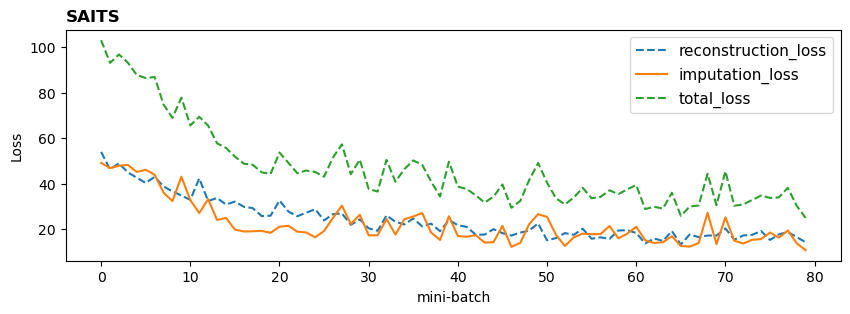

In [6]:
import matplotlib.pyplot as plt
def put_Learning_curve(loss1, loss2,loss3, AX, letter):
    AX.plot(loss1,  label = "reconstruction_loss", linestyle="--")
    AX.plot(loss2,  label = "imputation_loss", linestyle="-")
    AX.plot(loss3,  label = "total_loss", linestyle="--")
    
    
    
    AX.legend(loc="upper right", fontsize=11)
    AX.set_ylabel('Loss')
    AX.set_xlabel("mini-batch")
    #AX.set_ylim(0.4, 1.1)
    AX.set_title(letter, fontsize = 12,  fontweight ="bold", loc='left')

fig = plt.figure(figsize=(10,3))
ax0 = plt.subplot2grid((1, 1), (0, 0))
put_Learning_curve(all_losses_and_MAEs['reconstruction_loss'], all_losses_and_MAEs['imputation_loss'], 
                   all_losses_and_MAEs['total_loss'], 
                   ax0, 'SAITS')

In [7]:
#model.impute()


def get_inputs_for_imputation(loader):  
    idxs   = list()
    full_X = list()
    full_missing_mask = list()
    for indices, X, missing_mask, X_holdout, indicating_mask in loader.dataset:
        idxs.append(indices.reshape(1))
        full_X.append(X.reshape(1,9,51))
        full_missing_mask.append(missing_mask.reshape(1,9,51))
    return {'indices':      torch.cat(idxs).to('cuda'), 
            'X':            torch.cat(full_X).to('cuda'), 
            'missing_mask': torch.cat(full_missing_mask).to('cuda')}

val    = LoadValTestDataset('data/datasets.h5', 'val', 9, 51)
loader_val = DataLoader(val, batch_size=1)
train = LoadTrainDataset('data/datasets.h5', seq_len = 9, feature_num = 51, masked_imputation_task= True)
loader_train = DataLoader(train, batch_size=1)


model.eval

model.impute(get_inputs_for_imputation(loader_train))[0].__len__(), model.impute(get_inputs_for_imputation(loader_val))[0].__len__()

(15, 4)

In [8]:
import pickle
import pandas as pd


def get_DFs(loader, set_ids):
    

    df_list = []


    i = 0
    for i in range(len(list(loader))):
        i_df = pd.DataFrame(model.impute(get_inputs_for_imputation(lmodeloader))[0][i].cpu().detach())

        with open('data/sets_ids_splitted.pickle', 'rb') as handle:
            sets_ids_splitted = pickle.load(handle)
            
            
        sets_ids_splitted[set_ids].__len__()



        i_df['codigo'] =  sets_ids_splitted[set_ids][i]


        i_df.set_index('codigo', inplace=True)
        df_list.append(i_df)
        
    return df_list

In [9]:




train_df_list = get_DFs(loader_train, 'train_set_ids')
val_df_list = get_DFs(loader_val, 'val_set_ids')

train_imputed = pd.concat(train_df_list).abs()
val_imputed   = pd.concat(val_df_list).abs()



pd.concat([train_imputed, val_imputed]).to_csv('data/all_data_imputed.csv')
